# This Notebook Runs a Very Simple Downstream Task

It's to demonstrate that the errors introduced by the invariant based embeddor are not significant

In [1]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from embedding import NaiveEmbeddor, ReconstructEmbeddor, CheapEmbeddor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim

In [2]:
data = scipy.io.loadmat("1_label.mat")
labels = data["volLabel"]
print(labels.shape)

(1, 1439)


In [3]:
def show(chunk):
    """
    Given a 2-dimensional greyscale rep of an image, show it
    """
    plt.imshow(chunk, cmap="gray", vmin=0.0, vmax=1.0)
    plt.axis("off")
    plt.show()

def show2(chunk1, chunk2):
    """
    Given two 2-dimensional grayscale representations of images, show them side by side.
    """
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(chunk1.squeeze(), cmap="gray", vmin=0.0, vmax=1.0)
    axes[0].axis("off")
    axes[1].imshow(chunk2.squeeze(), cmap="gray", vmin=0.0, vmax=1.0)
    axes[1].axis("off")
    plt.show()

In [4]:
gen = 3
with open(f"embeddor_runs/gen{gen}/naive.pkl", "rb") as fin:
    naive = pickle.load(fin)
with open(f"embeddor_runs/gen{gen}/reconstruct.pkl", "rb") as fin:
    reconstruct = pickle.load(fin)
with open(f"embeddor_runs/gen{gen}/cheap.pkl", "rb") as fin:
    cheap = pickle.load(fin)

In [5]:
class AbnormalDataset(Dataset):
    def __init__(self, beds, labels):
        self.beds = beds
        self.labels = labels
    
    def __len__(self):
        return len(self.beds)
    
    def __getitem__(self, ix):
        bed = torch.from_numpy(self.beds[ix])
        raw_label = self.labels[:, ix][0]
        label = 1.0 if np.sum(raw_label) > 0.0 else 0.0
        return (bed, label)

In [6]:
class Classifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, output_size),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.model(x)

In [7]:
def evaluate_model(model, test_loader, criterion):
    """
    Helper function to evaluate a model against a dataloader
    """
    model.eval()
    test_loss = 0.0
    num_correct = 0
    num_total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, expected = data
            outputs = model(inputs)
            expected = expected.to(torch.float32).reshape(outputs.shape)
            loss = criterion(outputs, expected)
            test_loss += loss.item() * inputs.size(0)
            out_round = outputs.numpy().round()
            expected_round = expected.numpy().round()
            correct = out_round == expected_round
            num_correct += np.sum(correct)
            num_total += 16
    return test_loss / len(test_loader.dataset), num_correct / num_total

def train_model(
    model,
    train_loader: DataLoader,
    test_loader: DataLoader,
    num_epochs: int,
    optimizer=None
) -> ((list[float], list[float]), optim.Adam):
    """
    Trains the given model on the given train/test datasets for the given number of epochs.
    Optionally takes an optimizer so you can continue to train by calling this function again.
    Returns tuple of three things:
        list of training losses
        list of testing losses
        the optimizer used (in case you want to keep training)
    """
    criterion = nn.BCELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001) if optimizer is None else optimizer
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        num_correct = 0
        num_total = 0
        num_nonzero = 0
        for data in train_loader:
            inputs, expected = data
            optimizer.zero_grad()
            outputs = model(inputs)
            expected = expected.to(torch.float32).reshape(outputs.shape)
            loss = criterion(outputs, expected)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            out_round = outputs.detach().numpy().round()
            num_nonzero += np.sum(out_round)
            expected_round = expected.numpy().round()
            correct = out_round == expected_round
            num_correct += np.sum(correct)
            num_total += 16
        print("num non zero guesses:", num_nonzero)

        # Calculate average loss for training set
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_acc = num_correct / num_total
        train_accs.append(train_acc)

        # Calculate average loss for test set
        test_loss, test_acc = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    return (train_losses, train_accs, test_losses, test_accs, optimizer)

def experiment(dataset, num_epochs=50):
    batch_size = 16
    num_samples = len(naive_dataset)
    indices = list(range(num_samples))
    train_size = int(0.7 * num_samples)
    train_indices, test_indices = indices[:train_size], indices[train_size:]

    train_dataset = Subset(naive_dataset, train_indices)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = Subset(naive_dataset, test_indices)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = Classifier(7360, 1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    return train_model(model, train_dataloader, test_dataloader, num_epochs, optimizer)

In [8]:
naive_dataset = AbnormalDataset(naive.beds, labels)
(train_loss, train_accs, test_losses, test_accs, _) = experiment(naive_dataset, num_epochs=200)

num non zero guesses: 229.0
Epoch [1/200], Train Loss: 1.1031, Train Acc: 0.6270 Test Loss: 0.6261, Test Acc: 0.7824
num non zero guesses: 22.0
Epoch [2/200], Train Loss: 0.6953, Train Acc: 0.6736 Test Loss: 0.6485, Test Acc: 0.7824
num non zero guesses: 19.0
Epoch [3/200], Train Loss: 0.7095, Train Acc: 0.6964 Test Loss: 0.6401, Test Acc: 0.7824
num non zero guesses: 32.0
Epoch [4/200], Train Loss: 0.7089, Train Acc: 0.6617 Test Loss: 0.6444, Test Acc: 0.7824
num non zero guesses: 1.0
Epoch [5/200], Train Loss: 0.6688, Train Acc: 0.6865 Test Loss: 0.6481, Test Acc: 0.7824
num non zero guesses: 2.0
Epoch [6/200], Train Loss: 0.6855, Train Acc: 0.6855 Test Loss: 0.6437, Test Acc: 0.7824
num non zero guesses: 90.0
Epoch [7/200], Train Loss: 0.7419, Train Acc: 0.6736 Test Loss: 0.6244, Test Acc: 0.7824
num non zero guesses: 0.0
Epoch [8/200], Train Loss: 0.6522, Train Acc: 0.6875 Test Loss: 0.6207, Test Acc: 0.7824
num non zero guesses: 0.0
Epoch [9/200], Train Loss: 0.6719, Train Acc: 0.

In [9]:
cheap_dataset = AbnormalDataset(cheap.beds, labels)
(cheap_train_loss, cheap_train_accs, cheap_test_losses, cheap_test_accs, _) = experiment(cheap_dataset, num_epochs=200)

num non zero guesses: 221.0
Epoch [1/200], Train Loss: 0.9922, Train Acc: 0.6429 Test Loss: 0.6191, Test Acc: 0.7824
num non zero guesses: 83.0
Epoch [2/200], Train Loss: 0.8716, Train Acc: 0.6409 Test Loss: 0.6209, Test Acc: 0.7824
num non zero guesses: 77.0
Epoch [3/200], Train Loss: 0.7083, Train Acc: 0.6250 Test Loss: 0.6706, Test Acc: 0.7824
num non zero guesses: 24.0
Epoch [4/200], Train Loss: 0.7167, Train Acc: 0.6776 Test Loss: 0.6589, Test Acc: 0.7824
num non zero guesses: 15.0
Epoch [5/200], Train Loss: 0.6870, Train Acc: 0.6766 Test Loss: 0.6524, Test Acc: 0.7824
num non zero guesses: 2.0
Epoch [6/200], Train Loss: 0.6779, Train Acc: 0.6855 Test Loss: 0.6487, Test Acc: 0.7824
num non zero guesses: 0.0
Epoch [7/200], Train Loss: 0.6691, Train Acc: 0.6875 Test Loss: 0.6370, Test Acc: 0.7824
num non zero guesses: 60.0
Epoch [8/200], Train Loss: 0.7015, Train Acc: 0.6577 Test Loss: 0.6275, Test Acc: 0.7824
num non zero guesses: 1.0
Epoch [9/200], Train Loss: 0.6859, Train Acc: 0

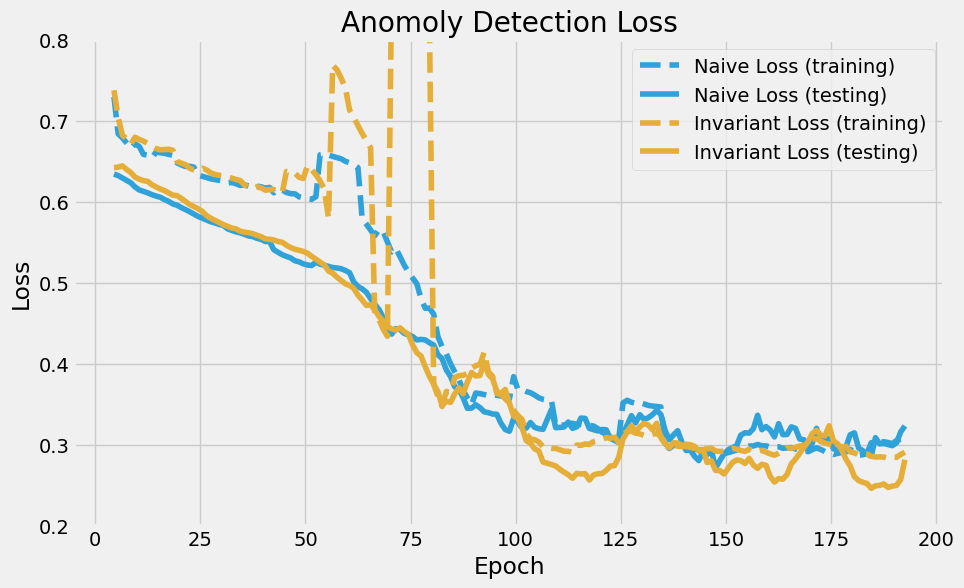

In [37]:
CUTOFF = 199
AVERAGE = 10

def clean(y):
    result = []
    for ix in range(CUTOFF - AVERAGE):
        result.append(sum(y[ix:ix + AVERAGE]) / AVERAGE)

    return result


plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10, 6))
x = list(range(CUTOFF))
ax.plot(clean(x), clean(train_loss), color="#30a2da", linestyle="--", label="Naive Loss (training)")
ax.plot(clean(x), clean(test_losses), color="#30a2da", label="Naive Loss (testing)")
ax.plot(clean(x), clean(cheap_train_loss), color="#e5ae38", linestyle="--", label="Invariant Loss (training)")
ax.plot(clean(x), clean(cheap_test_losses), color="#e5ae38", label="Invariant Loss (testing)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_ylim(0.2, 0.8)
ax.set_title("Anomoly Detection Loss")
ax.legend()
plt.show()

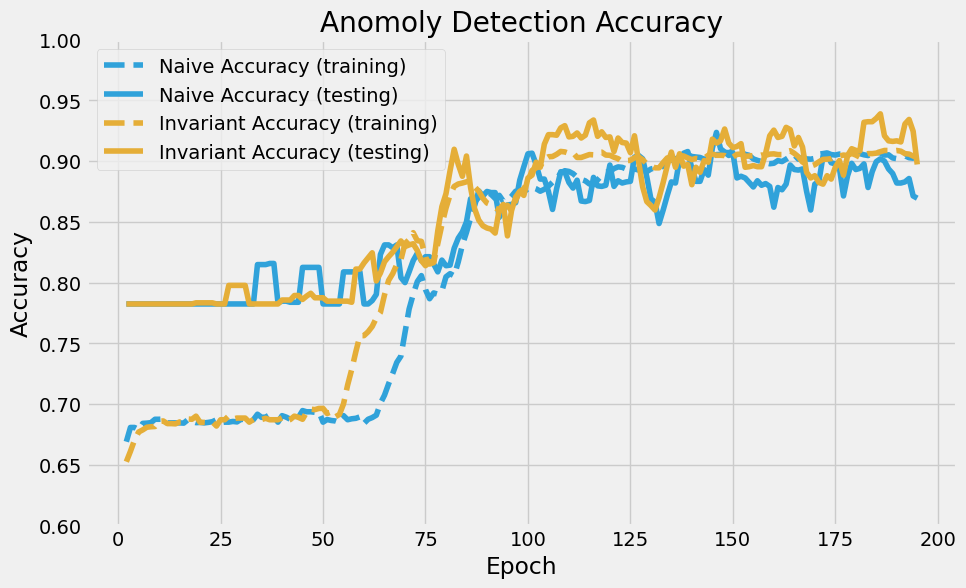

In [39]:
CUTOFF = 199
AVERAGE = 5

def clean(y):
    result = []
    for ix in range(CUTOFF - AVERAGE):
        result.append(sum(y[ix:ix + AVERAGE]) / AVERAGE)

    return result


plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10, 6))
x = list(range(CUTOFF))
ax.plot(clean(x), clean(train_accs), color="#30a2da", linestyle="--", label="Naive Accuracy (training)")
ax.plot(clean(x), clean(test_accs), color="#30a2da", label="Naive Accuracy (testing)")
ax.plot(clean(x), clean(cheap_train_accs), color="#e5ae38", linestyle="--", label="Invariant Accuracy (training)")
ax.plot(clean(x), clean(cheap_test_accs), color="#e5ae38", label="Invariant Accuracy (testing)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_ylim(0.6, 1.0)
ax.set_title("Anomoly Detection Accuracy")
ax.legend()
plt.show()